Импортируем необходимые библиотеки:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ["OMP_NUM_THREADS"] = '1'
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score

In [3]:
# Загрузка данных
df = pd.read_csv("pokemon.csv")

In [4]:
print("Первые 5 строк:")
print(df.head())

Первые 5 строк:
            Name  Total  HP  Attack  Defence  Sp_attack  Sp_defence  Speed
0      Bulbasaur    318  45      49       49         65          65     45
1        Ivysaur    405  60      62       63         80          80     60
2       Venusaur    525  80      82       83        100         100     80
3  Mega Venusaur    625  80     100      123        122         120     80
4     Charmander    309  39      52       43         60          50     65


### Описание признаков полей

Name - Имя покемона<br>
Total - Общая сила покемона<br>
HP - Очки здоровья<br>
Attack - Урон от атаки<br>
Defence - Защита от атак<br>
Sp_attack - Урон от спец атаки<br>
Sp_defence - Защита от спец атак<br>
Speed - Скорость<br>

In [7]:
print("\nИнформация о данных:")
print(df.info())


Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045 entries, 0 to 1044
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Name        1045 non-null   object
 1   Total       1045 non-null   int64 
 2   HP          1045 non-null   int64 
 3   Attack      1045 non-null   int64 
 4   Defence     1045 non-null   int64 
 5   Sp_attack   1045 non-null   int64 
 6   Sp_defence  1045 non-null   int64 
 7   Speed       1045 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 65.4+ KB
None


In [8]:
print("\nСтатистика числовых признаков:")
print(df.describe())


Статистика числовых признаков:
             Total           HP       Attack      Defence    Sp_attack  \
count  1045.000000  1045.000000  1045.000000  1045.000000  1045.000000   
mean    439.314833    70.067943    80.466986    74.661244    73.022010   
std     121.970701    26.671411    32.413665    31.237903    32.724797   
min     175.000000     1.000000     5.000000     5.000000    10.000000   
25%     330.000000    50.000000    55.000000    50.000000    50.000000   
50%     458.000000    68.000000    77.000000    70.000000    65.000000   
75%     515.000000    82.000000   100.000000    90.000000    95.000000   
max    1125.000000   255.000000   190.000000   250.000000   194.000000   

        Sp_defence        Speed  
count  1045.000000  1045.000000  
mean     72.288995    68.807656  
std      28.074148    30.210094  
min      20.000000     5.000000  
25%      50.000000    45.000000  
50%      70.000000    65.000000  
75%      90.000000    90.000000  
max     250.000000   200.0000

Выводы:
- Все признаки, кроме Name, числовые.<br>
- Нет пропущенных значений.<br>

### Разведочный анализ (EDA)

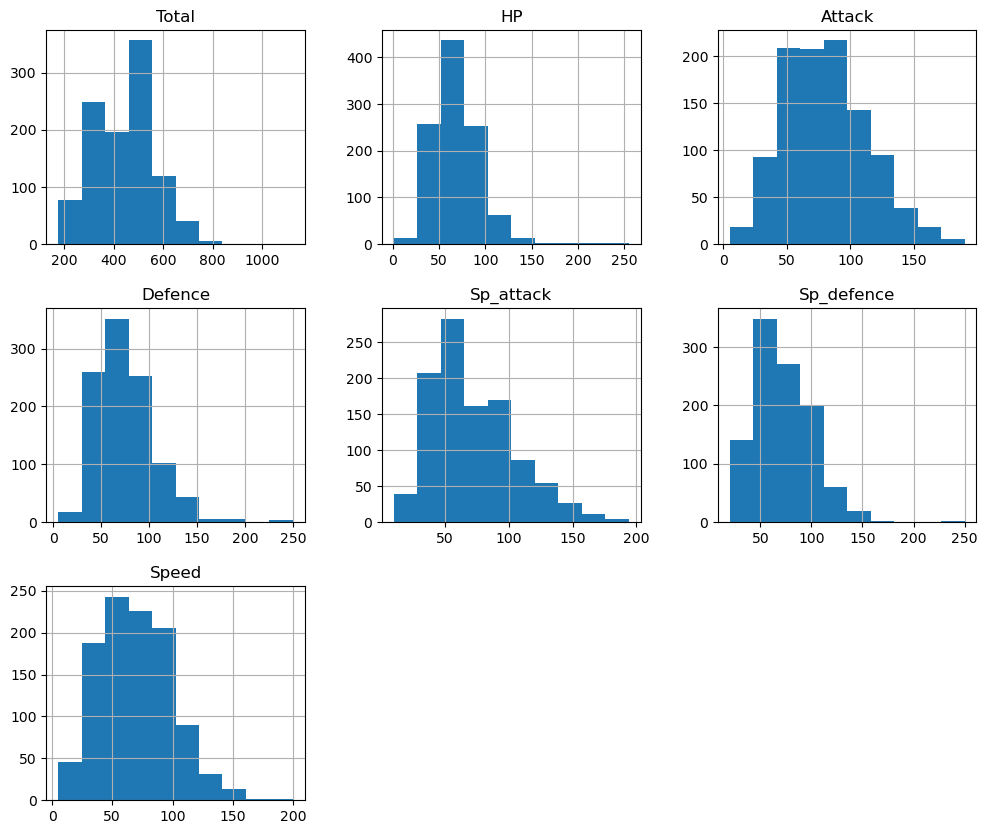

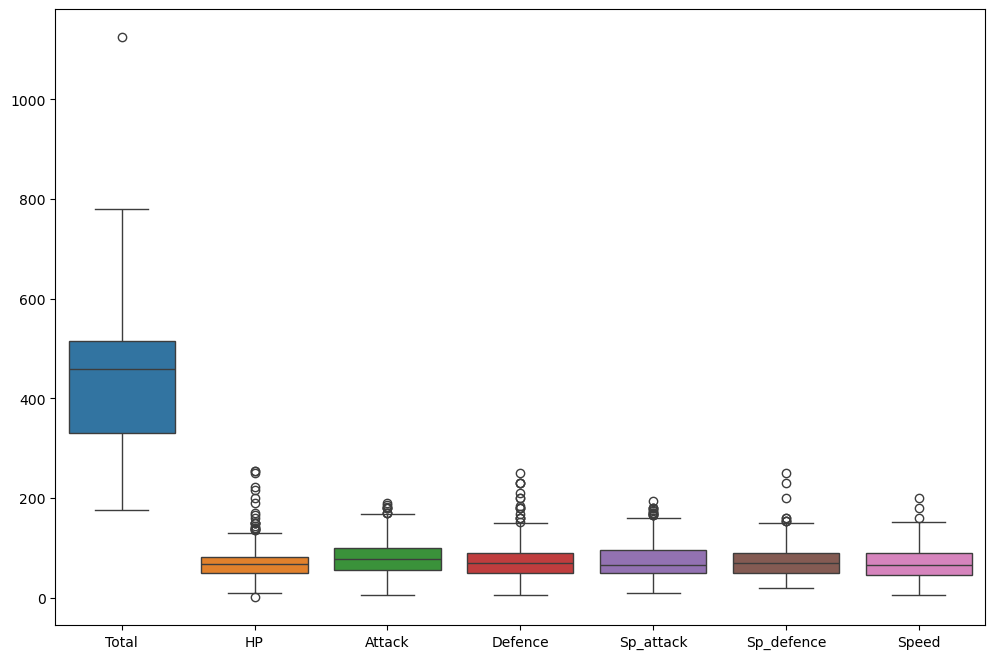

In [11]:
# Гистограммы для числовых переменных
df.hist(figsize=(12, 10))
plt.show()

# Boxplot для числовых переменных
plt.figure(figsize=(12, 8))
sns.boxplot(data=df)
plt.show()

Выводы:
- Признаки HP, Attack, Defence имеют близкие к нормальному распределения.
- Speed и Sp_attack имеют правосторонние выбросы.
- Total сильно варьируется (от 195 до 780).

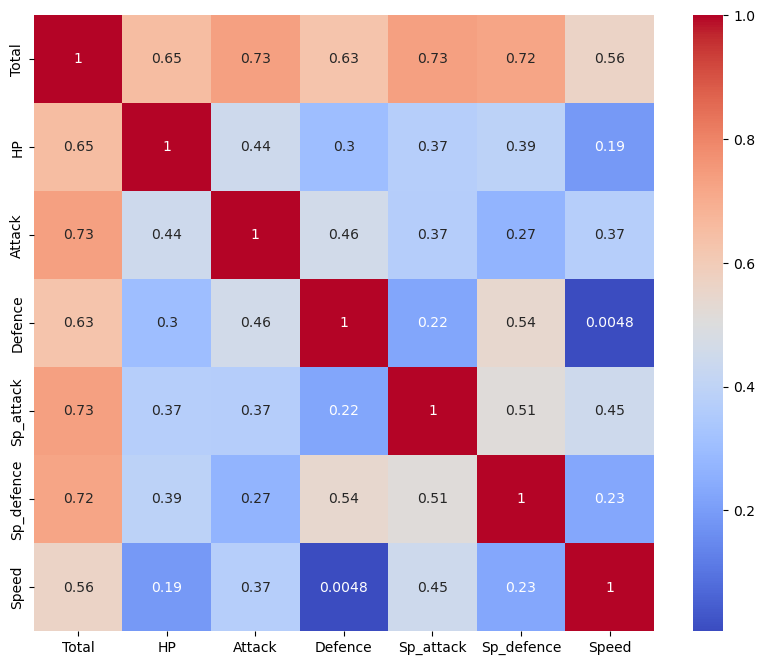

In [13]:
# Матрица корреляций
corr_matrix = df.drop(columns=['Name']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

Выводы:
- Total сильно коррелирует с другими признаками (особенно с Sp_attack, Attack, Sp_defence), что логично, так как это суммарный показатель.

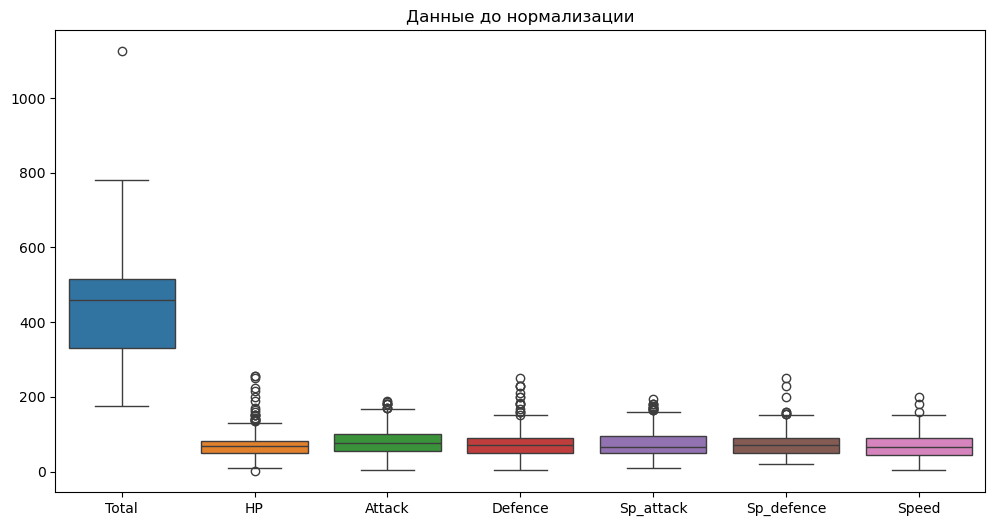

In [15]:
# Проверка распределения до нормализации
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.title("Данные до нормализации")
plt.show()

In [16]:
# Нормализация данных
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.drop("Name", axis=1))
df_scaled = pd.DataFrame(scaled_data, columns=df.columns[1:])

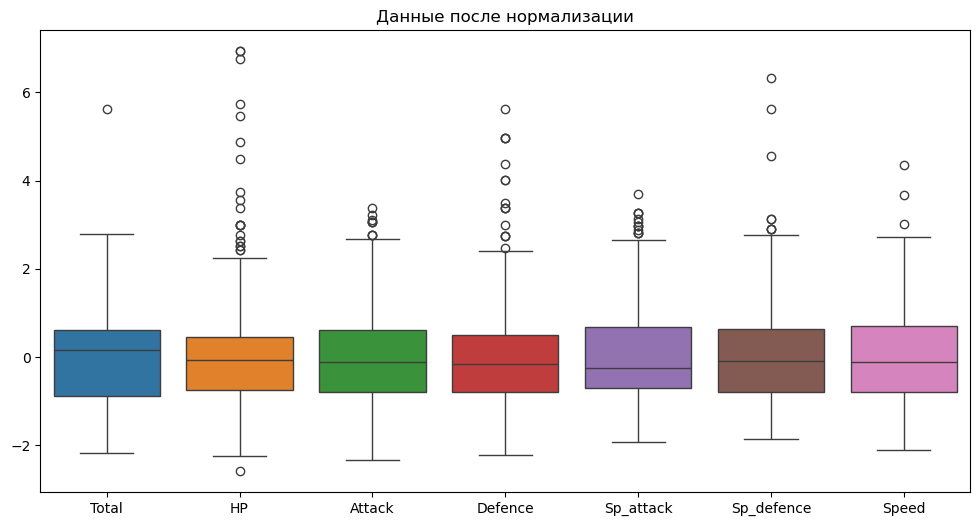

In [17]:
# Проверка распределения после нормализации
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_scaled)
plt.title("Данные после нормализации")
plt.show()

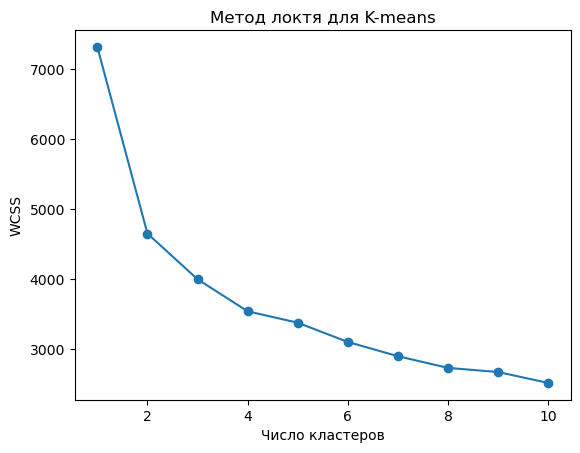

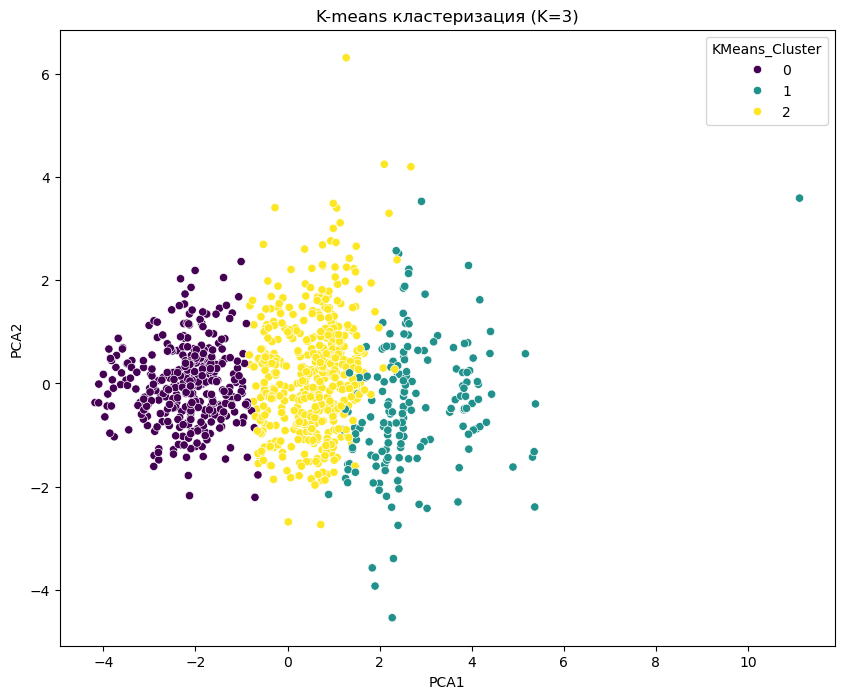

Силуэтный коэффициент (K=3): 0.26


In [18]:
# Определение оптимального числа кластеров (метод локтя)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker="o")
plt.title("Метод локтя для K-means")
plt.xlabel("Число кластеров")
plt.ylabel("WCSS")
plt.show()

# Кластеризация с K=3
kmeans = KMeans(n_clusters=3, random_state=42)
clusters_kmeans = kmeans.fit_predict(df_scaled)
df["KMeans_Cluster"] = clusters_kmeans

# Визуализация через PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)
df["PCA1"] = pca_result[:, 0]
df["PCA2"] = pca_result[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(x="PCA1", y="PCA2", hue="KMeans_Cluster", data=df, palette="viridis")
plt.title("K-means кластеризация (K=3)")
plt.show()

# Оценка силуэтным коэффициентом
print(f"Силуэтный коэффициент (K=3): {silhouette_score(df_scaled, clusters_kmeans):.2f}")

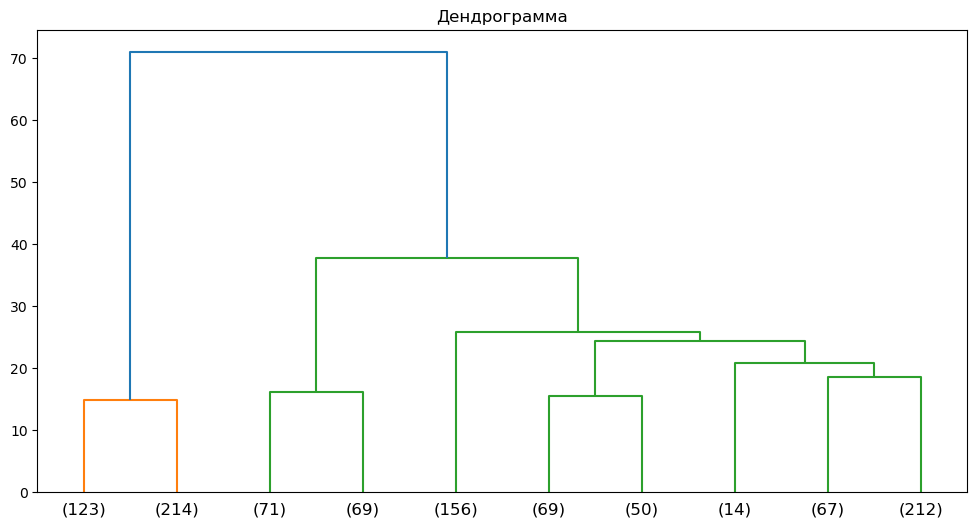

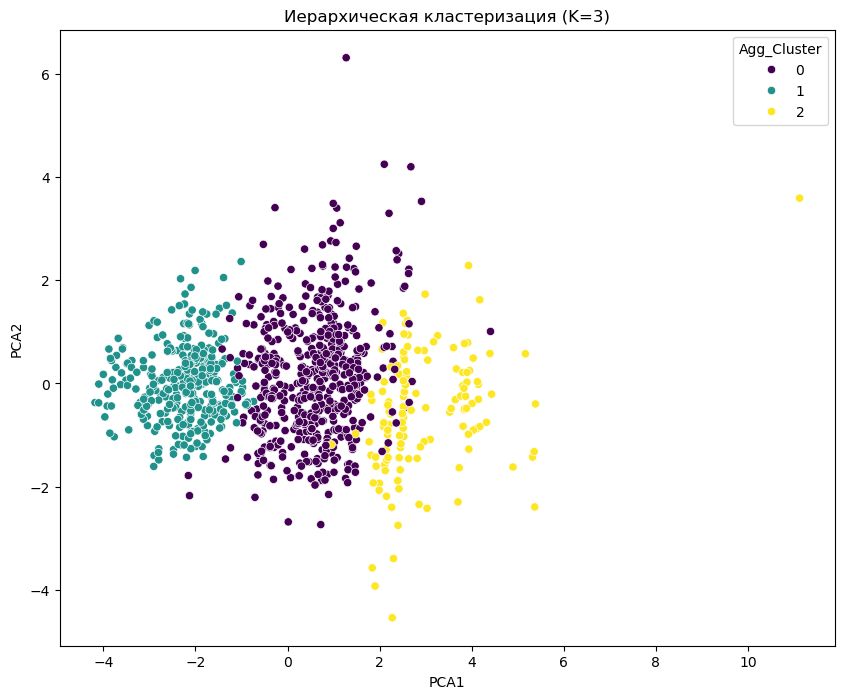

Силуэтный коэффициент (Agg): 0.26


In [19]:
# Построение дендрограммы
linked = linkage(df_scaled, method="ward")
plt.figure(figsize=(12, 6))
dendrogram(linked, orientation="top", truncate_mode="lastp", p=10)
plt.title("Дендрограмма")
plt.show()

# Кластеризация с K=3
agg_clustering = AgglomerativeClustering(n_clusters=3)
clusters_agg = agg_clustering.fit_predict(df_scaled)
df["Agg_Cluster"] = clusters_agg

# Визуализация
plt.figure(figsize=(10, 8))
sns.scatterplot(x="PCA1", y="PCA2", hue="Agg_Cluster", data=df, palette="viridis")
plt.title("Иерархическая кластеризация (K=3)")
plt.show()

# Силуэтный коэффициент
print(f"Силуэтный коэффициент (Agg): {silhouette_score(df_scaled, clusters_agg):.2f}")

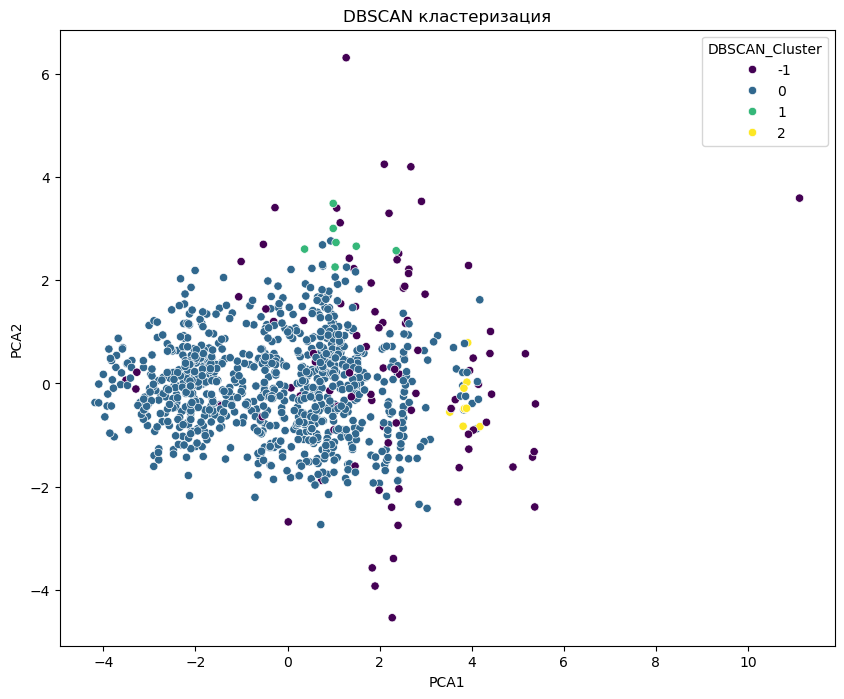

Силуэтный коэффициент (DBSCAN): 0.22


In [20]:
# Кластеризация DBSCAN
dbscan = DBSCAN(eps=1.3, min_samples=5)
clusters_dbscan = dbscan.fit_predict(df_scaled)
df["DBSCAN_Cluster"] = clusters_dbscan

# Визуализация
plt.figure(figsize=(10, 8))
sns.scatterplot(x="PCA1", y="PCA2", hue="DBSCAN_Cluster", data=df, palette="viridis")
plt.title("DBSCAN кластеризация")
plt.show()

# Силуэтный коэффициент (игнорируя шум)
valid_clusters = clusters_dbscan != -1
print(f"Силуэтный коэффициент (DBSCAN): {silhouette_score(df_scaled[valid_clusters], clusters_dbscan[valid_clusters]):.2f}")

In [21]:
# Метрики качества кластеризации
def evaluate_clustering(true_labels, pred_labels, method_name):
    print(f"Метрики для {method_name}:")
    print("Homogeneity:", homogeneity_score(true_labels, pred_labels))
    print("Completeness:", completeness_score(true_labels, pred_labels))
    print("V-measure:", v_measure_score(true_labels, pred_labels))
    print("Adjusted Rand Index:", adjusted_rand_score(true_labels, pred_labels))
    print("Adjusted Mutual Info Score:", adjusted_mutual_info_score(true_labels, pred_labels))
    print("\n")

evaluate_clustering(df['Total'], clusters_kmeans, "K-Means")
evaluate_clustering(df['Total'], clusters_agg, "Agg_Cluster")
evaluate_clustering(df['Total'], clusters_dbscan, "DBSCAN")

Метрики для K-Means:
Homogeneity: 0.19645318447372584
Completeness: 0.9187136533799932
V-measure: 0.3236900824155699
Adjusted Rand Index: 0.03471374408950687
Adjusted Mutual Info Score: 0.2656312500403771


Метрики для Agg_Cluster:
Homogeneity: 0.18351687535013064
Completeness: 0.9113291323470457
V-measure: 0.30551195987031193
Adjusted Rand Index: 0.02727887727790011
Adjusted Mutual Info Score: 0.24766314204514697


Метрики для DBSCAN:
Homogeneity: 0.04014537868105755
Completeness: 0.4927885512970317
V-measure: 0.07424253510119894
Adjusted Rand Index: 9.391355595120148e-05
Adjusted Mutual Info Score: 0.025248482038358288




### Классификация

In [23]:
# Подготовка данных
X = df_scaled
y = df["KMeans_Cluster"]

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Инициализация моделей
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(kernel="rbf", random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Обучение и оценка моделей
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(name)
    print(classification_report(y_test, y_pred))

Logistic Regression
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       103
           1       1.00      0.94      0.97        50
           2       0.97      0.99      0.98       161

    accuracy                           0.98       314
   macro avg       0.99      0.97      0.98       314
weighted avg       0.98      0.98      0.98       314

SVM
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       103
           1       0.96      0.86      0.91        50
           2       0.95      0.99      0.97       161

    accuracy                           0.97       314
   macro avg       0.97      0.95      0.96       314
weighted avg       0.97      0.97      0.97       314

K-Nearest Neighbors
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       103
           1       1.00      0.82      0.90        50
           2       0.94      1.